In [2]:

import pandas as pd
import numpy as np
import pywt
import pandas as pd 
from scipy.stats import skew, kurtosis, median_abs_deviation, moment
import math 
import scipy
import matplotlib.pyplot as plt 
import pywt
import pandas as pd 
import copy
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import lime
from lime import lime_tabular

2024-08-21 21:12:21.426499: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 21:12:21.436618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 21:12:21.448608: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 21:12:21.452169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 21:12:21.460304: I tensorflow/core/platform/cpu_feature_guar

In [3]:
def rmsValue(array):
    n = len(array)
    squre = 0.0
    root = 0.0
    mean = 0.0
    for i in range(0, n):
        squre += (array[i] ** 2)
    mean = (squre/ (float)(n))
    root = math.sqrt(mean)
    return root

def peak_to_rms_1D(array):

    return np.max(np.abs(array))/rmsValue(array)

def signal_range_1D(array):

    return np.max(array) - np.min(array)


def stats_from_WD(s_signal, wv_type, decomp_lvl):
    coeffs  = pywt.wavedec(s_signal, wv_type, level = decomp_lvl)
    ft_vec = []

    for comp in coeffs:
     ft_vec.append( [np.mean(comp), np.var(comp), np.std(comp), rmsValue(comp),
                   skew(comp), kurtosis(comp), peak_to_rms_1D(comp), rmsValue(comp)/np.mean(np.abs(comp)),
                      median_abs_deviation(comp), moment(comp, moment=2), np.min(comp),
                     np.max(comp), signal_range_1D(comp)] )

    ft_vec = np.reshape(ft_vec, (len(coeffs)*len(ft_vec[0])),) # 1,52
    return ft_vec


def get_train_ft(train_data, dc_type,  dc_lvl):
    
    train_features = []
    for i in range(len(train_data)):
        ft_vec = stats_from_WD(train_data[i,:], dc_type, dc_lvl)
        train_features.append(ft_vec)


    train_features = np.array(train_features)
    
    return train_features

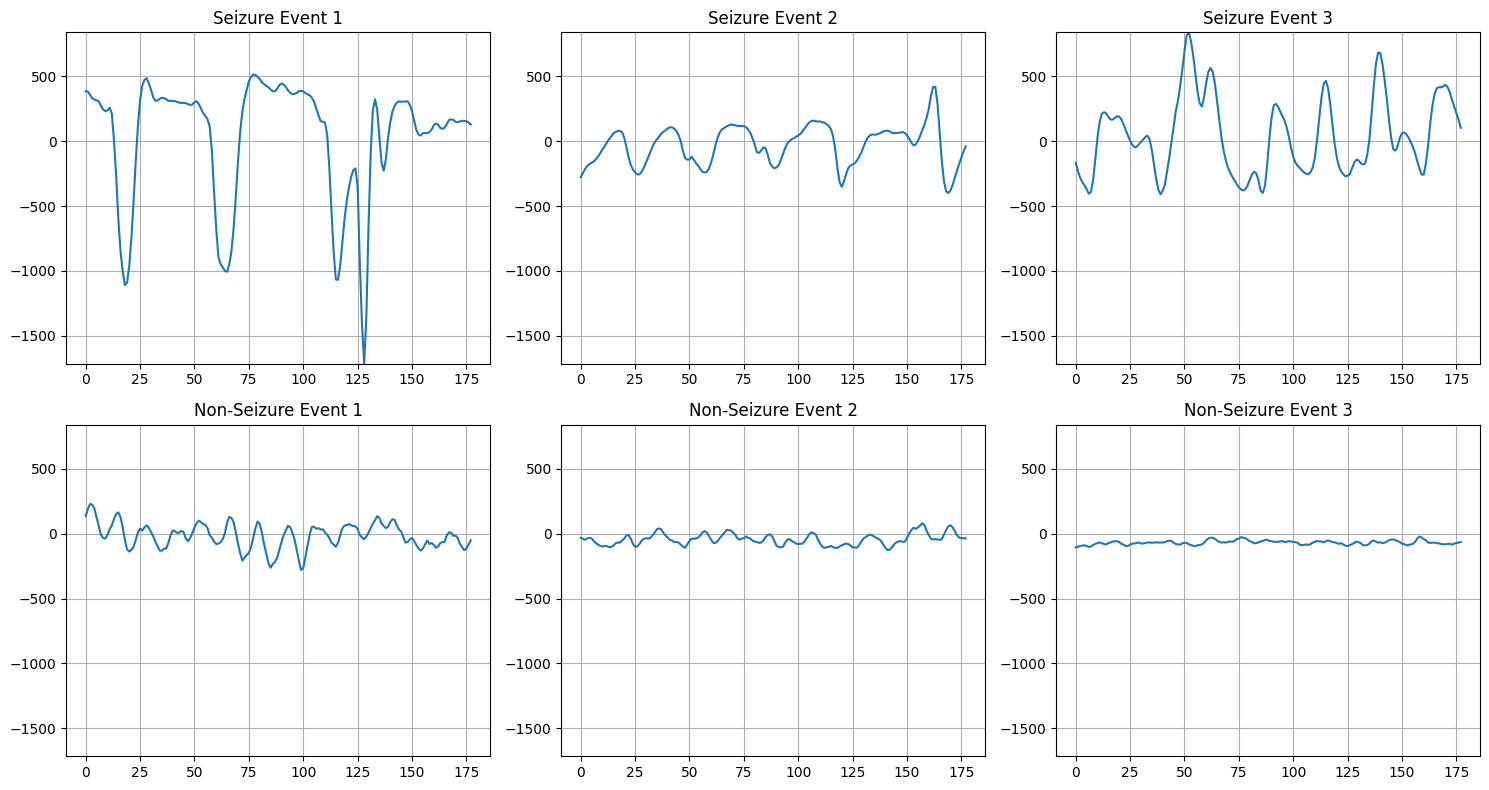

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# Extract labels and features
train_labels = train_data.iloc[:, -1].values
train_data = train_data.iloc[:, 1:-1].values

# Convert seizure events to binary classes (1 - Seizure, 0 - Non-Seizure)
train_labels = np.where(train_labels == 1, 1, 0)

# Get indices for seizure (label = 1) and non-seizure (label = 0) events
seizure_indices = np.where(train_labels == 1)[0]
non_seizure_indices = np.where(train_labels == 0)[0]

# Select 3 random seizure and non-seizure events
random_seizure_samples = seizure_indices[:3]  # Taking first 3 seizure samples
random_non_seizure_samples = non_seizure_indices[:3]  # Taking first 3 non-seizure samples

# Find global y limits across all signals for consistent scaling
all_samples = np.concatenate([train_data[random_seizure_samples], train_data[random_non_seizure_samples]])
y_min, y_max = np.min(all_samples), np.max(all_samples)

# Plot 3 seizure events
plt.figure(figsize=(15, 8))

for i, idx in enumerate(random_seizure_samples, 1):
    plt.subplot(2, 3, i)
    plt.plot(train_data[idx])
    plt.title(f"Seizure Event {i}")
    plt.ylim([y_min, y_max])  # Set the same y-scale for all plots
    plt.grid(True)

# Plot 3 non-seizure events
for i, idx in enumerate(random_non_seizure_samples, 1):
    plt.subplot(2, 3, i+3)
    plt.plot(train_data[idx])
    plt.title(f"Non-Seizure Event {i}")
    plt.ylim([y_min, y_max])  # Set the same y-scale for all plots
    plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [5]:
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')
train_labels = train_data.iloc[:,-1]
train_labels = np.array(train_labels, dtype=np.int16)
feat_type = "DWT"    
standard_scaler = True 

if feat_type == "Time":
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   #train_data = sc.fit_transform(train_data)
elif feat_type == "DWT":
   dwt_base = "db4"
   dwt_dc_level = 3
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   print("Extracting DWT-based features\n")
   train_data = get_train_ft(train_data, dwt_base, dwt_dc_level)


train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure
n_lab = np.unique(train_labels)   
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

if standard_scaler:
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)


counts = []
for i in range(len(n_lab)):
    counts.append(np.sum(train_labels==i))
counts = counts/sum(counts)

print(f"Train data labels distributions: {counts*100}\n")

Extracting DWT-based features

Train data labels distributions: [80.14276444 19.85723556]



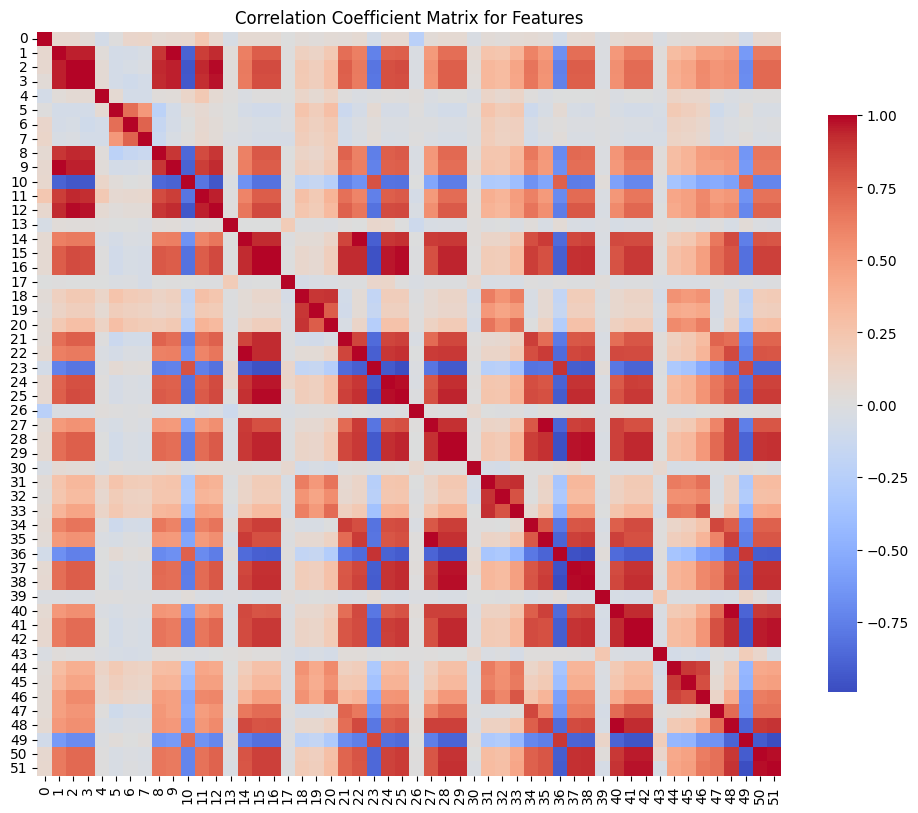

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset


# Extract labels and features
# train_labels = train_data.iloc[:, -1].values
# train_data = train_data.iloc[:, 1:-1].values

# # Convert seizure events to binary classes (1 - Seizure, 0 - Non-Seizure)
# train_labels = np.where(train_labels == 1, 1, 0)

# Select only the last 3 levels of DWT or specific features
# Assuming features have already been extracted, you can work with this:
# train_data = get_train_ft(train_data, 'db4', 4)  # Example extraction

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(train_data.T)  # Transpose for feature-wise correlation

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .75})
plt.title('Correlation Coefficient Matrix for Features')
plt.show()


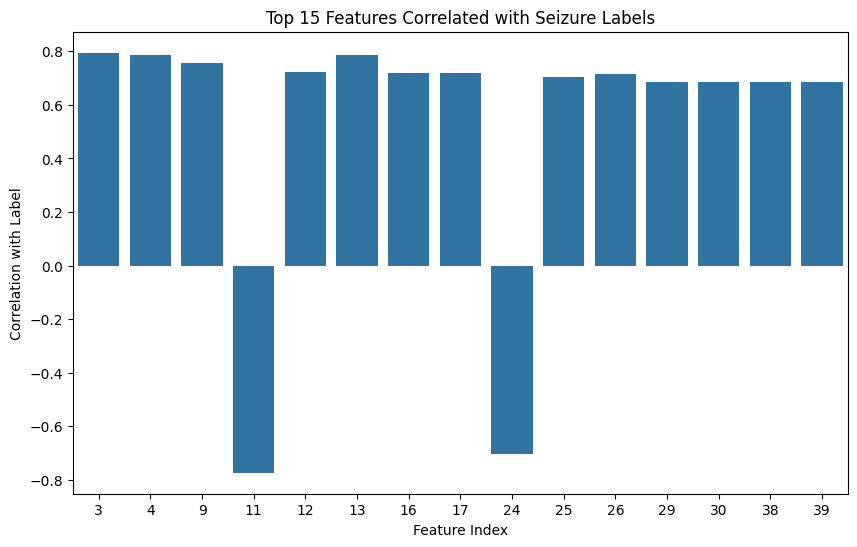

    Feature  Correlation_with_Label  Abs_Correlation
2         3                0.795017         0.795017
12       13                0.787463         0.787463
3         4                0.785014         0.785014
10       11               -0.773909         0.773909
8         9                0.755848         0.755848
11       12                0.721359         0.721359
16       17                0.720897         0.720897
15       16                0.720711         0.720711
25       26                0.716282         0.716282
24       25                0.704021         0.704021
23       24               -0.702320         0.702320
37       38                0.687121         0.687121
38       39                0.685508         0.685508
29       30                0.684541         0.684541
28       29                0.684518         0.684518


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
# train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# # Extract labels and features
# train_labels = train_data.iloc[:, -1].values
# train_data = train_data.iloc[:, 1:-1].values

# # Convert seizure events to binary classes (1 - Seizure, 0 - Non-Seizure)
# train_labels = np.where(train_labels == 1, 1, 0)

# Compute correlation with the label (train_labels)
correlations = []

for i in range(train_data.shape[1]):
    feature = train_data[:, i]
    correlation = np.corrcoef(feature, train_labels)[0, 1]
    correlations.append(correlation)

# Convert to dataframe for better visualization
correlation_df = pd.DataFrame({
    'Feature': range(1, train_data.shape[1] + 1), 
    'Correlation_with_Label': correlations
})

# Sort features by absolute correlation values
correlation_df['Abs_Correlation'] = np.abs(correlation_df['Correlation_with_Label'])
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False)

# Plot the top features by correlation with labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Correlation_with_Label', data=correlation_df.head(15))
plt.title('Top 15 Features Correlated with Seizure Labels')

plt.xlabel('Feature Index')
plt.ylabel('Correlation with Label')
plt.show()

# Print the correlation values
print(correlation_df.head(15))


/home/rakesh018/.local/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


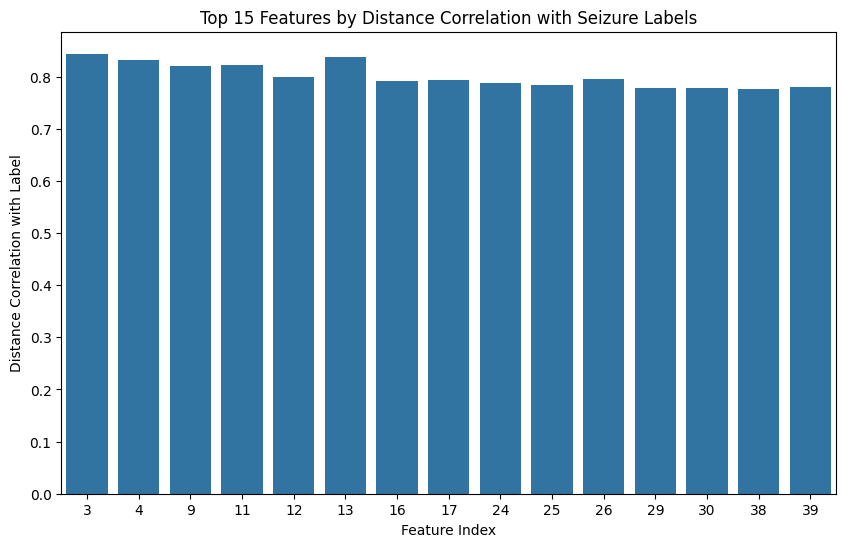

    Feature  Distance_Correlation_with_Label  Abs_Distance_Correlation
2         3                         0.843689                  0.843689
12       13                         0.837091                  0.837091
3         4                         0.832305                  0.832305
10       11                         0.822362                  0.822362
8         9                         0.819386                  0.819386
11       12                         0.798137                  0.798137
25       26                         0.795588                  0.795588
16       17                         0.792382                  0.792382
15       16                         0.792114                  0.792114
23       24                         0.787639                  0.787639
24       25                         0.784191                  0.784191
38       39                         0.780614                  0.780614
28       29                         0.777901                  0.777901
29    

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

# Load the dataset
# train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# # Extract labels and features
# train_labels = train_data.iloc[:, -1].values
# train_data = train_data.iloc[:, 1:-1].values

# # Convert seizure events to binary classes (1 - Seizure, 0 - Non-Seizure)
# train_labels = np.where(train_labels == 1, 1, 0)

# Convert train_labels to float for dcor computation
train_labels = train_labels.astype(np.float64)

# Compute Distance Correlation with the label
distance_correlations = []
for i in range(train_data.shape[1]):
    feature = train_data[:, i]
    dist_corr = dcor.distance_correlation(feature.astype(np.float64), train_labels)
    distance_correlations.append(dist_corr)

# Combine both Pearson and Distance correlations into a dataframe
correlation_df = pd.DataFrame({
    'Feature': range(1, train_data.shape[1] + 1), 
    'Distance_Correlation_with_Label': distance_correlations
})

# Sort by distance correlation
correlation_df['Abs_Distance_Correlation'] = np.abs(correlation_df['Distance_Correlation_with_Label'])
correlation_df = correlation_df.sort_values(by='Abs_Distance_Correlation', ascending=False)

# Plot the top 10 features by distance correlation
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Distance_Correlation_with_Label', data=correlation_df.head(15))
plt.title('Top 15 Features by Distance Correlation with Seizure Labels')
plt.xlabel('Feature Index')
plt.ylabel('Distance Correlation with Label')
plt.show()

# Print the correlation values
print(correlation_df.head(15))


In [13]:
import numpy as np
import pandas as pd

# Assuming `train_data` is already extracted by DWT and has the shape (num_samples, num_features)
print(f"Original train data shape: {train_data.shape}")  # Check the shape of the train_data

# Indices of the top 15 features based on Pearson and Distance correlation (0-indexed)
top_pearson_features = [2, 12, 3, 10, 8, 11, 25, 16, 15, 23, 24, 38, 28, 29, 37]
top_distance_features = [2, 12, 3, 10, 8, 11, 25, 16, 15, 23, 24, 38, 28, 29, 37]

# Combine both sets of features (remove duplicates)
top_features = list(set(top_pearson_features + top_distance_features))

# Filter the train_data to include only the top features
filtered_train_data = train_data[:, top_features]
filtered_test_data=test_data[:,top_features]

# If needed, reshape the data to have the last dimension as 1 (e.g., for CNN models)
# reshaped_train_data = filtered_train_data.reshape(filtered_train_data.shape[0], len(top_features), 1)


# Print the shape of the filtered and reshaped train data
print(f"Filtered train data shape: {filtered_train_data.shape}")
print(f"filtered test data shape : {filtered_test_data.shape}")

train_data=filtered_train_data
test_data=filtered_test_data



Original train data shape: (7705, 52)
Filtered train data shape: (7705, 15)
filtered test data shape : (3795, 15)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 15, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 15, 64)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 15, 64)    │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 15, 64)    │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 15, 64)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 15, 64)    │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 15, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 15, 64)    │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 15, 64)    │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 15, 64)    │     12,352 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 15, 64)    │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 15, 64)    │          0 │ activation[0][0], │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 15, 64)    │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 15, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 15, 64)    │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 15, 64)    │     12,352 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 15, 64)    │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 15, 64)    │          0 │ activation_1[0][… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 15, 64)    │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 15, 64)    │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9500 - loss: 0.1509 - val_accuracy: 0.9533 - val_loss: 0.1138
Epoch 2/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9608 - loss: 0.1014 - val_accuracy: 0.9650 - val_loss: 0.0867
Epoch 3/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9642 - loss: 0.0898 - val_accuracy: 0.9637 - val_loss: 0.0813
Epoch 4/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9684 - loss: 0.0750 - val_accuracy: 0.9663 - val_loss: 0.0763
Epoch 5/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9692 - loss: 0.0765 - val_accuracy: 0.9650 - val_loss: 0.0808
Epoch 6/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9737 - loss: 0.0743 - val_accuracy: 0.9663 - val_loss: 0.0802
Epoch 7/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9745 - loss: 0.0620 - val_accuracy: 0.9689 - val_loss: 0.0741
Epoch 8/25
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9707 - loss: 0.0752 - val_accuracy: 0.

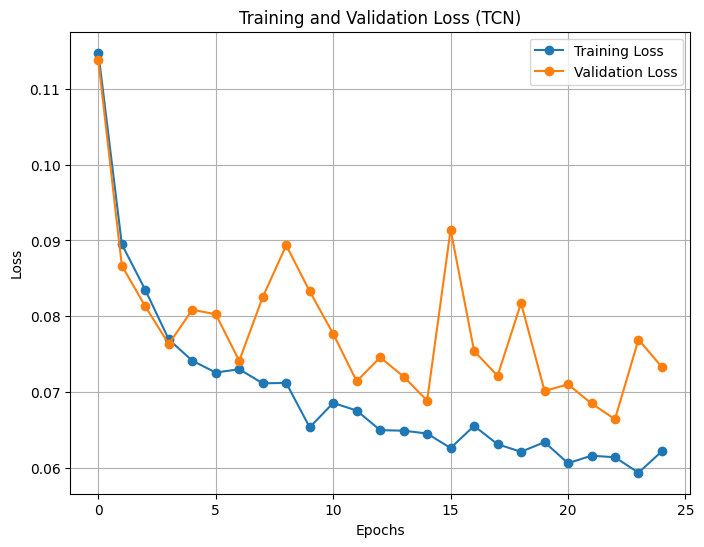

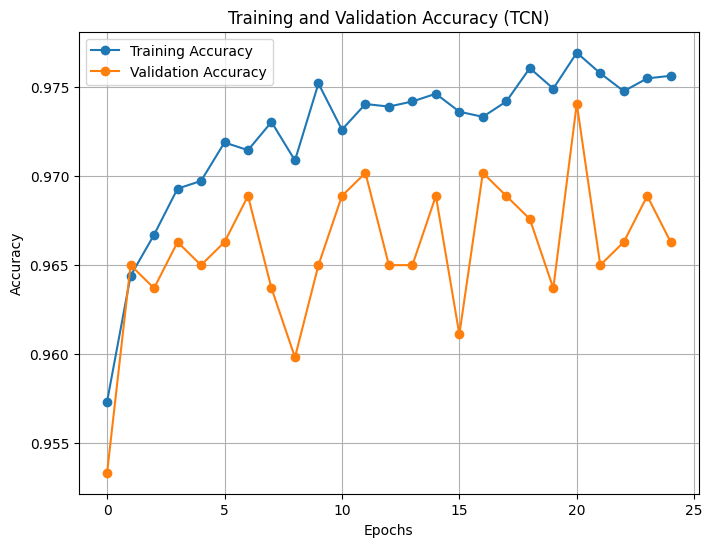

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9745 - loss: 0.0626
Test accuracy (TCN): 97.23%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report (TCN):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.93      0.94      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.96      0.96      3795
weighted avg       0.97      0.97      0.97      3795



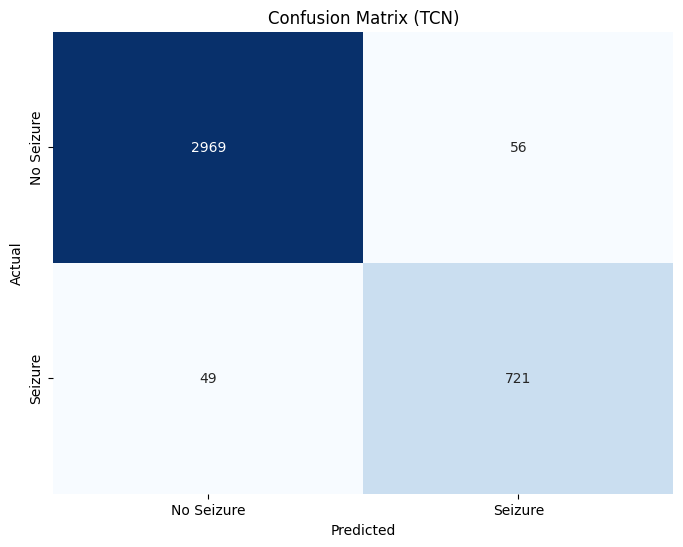

In [14]:
# Reshape data for TCN model
from tensorflow.keras import initializers
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

# Now, train_data.shape will be (7705, 52, 1)
# and test_data.shape will be (3795, 52, 1)

def create_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of residual blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the residual block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the residual block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Residual connection
        if x.shape[-1] != conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, conv2])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create TCN model
tcn_model = create_tcn(input_shape)

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model.summary()

# Train the model
history = tcn_model.fit(train_data, train_labels, epochs=25, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_tcn = tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN): {test_acc_tcn*100:.2f}%')

# Predict on test data
predictions = tcn_model.predict(test_data)
predictions_binary = (predictions > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 15, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 15, 32)    │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 7, 32)     │          0 │ conv1d_13[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 7, 64)     │      6,208 │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 3, 64)     │          0 │ conv1d_14[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 3, 64)     │     12,352 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 3, 64)     │          0 │ conv1d_15[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 3, 64)     │     12,352 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 3, 64)     │          0 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 3, 64)     │          0 │ max_pooling1d_4[… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 3, 64)     │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 3, 64)     │     12,352 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 3, 64)     │          0 │ conv1d_17[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 3, 64)     │     12,352 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 3, 64)     │          0 │ conv1d_18[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 3, 64)     │          0 │ activation_4[0][… │
│                     │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 3, 64)     │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 3, 64)     │     12,352 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 3, 64)     │          0 │ conv1d_19[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_20 (Conv1D)  │ (None, 3, 64)     │     12,352 │ dropout_12[0][0]

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9116 - loss: 0.1987 - val_accuracy: 0.9598 - val_loss: 0.1136
Epoch 2/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9681 - loss: 0.0748 - val_accuracy: 0.9650 - val_loss: 0.0828
Epoch 3/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9754 - loss: 0.0683 - val_accuracy: 0.9650 - val_loss: 0.0807
Epoch 4/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9719 - loss: 0.0709 - val_accuracy: 0.9637 - val_loss: 0.0758
Epoch 5/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9757 - loss: 0.0680 - val_accuracy: 0.9676 - val_loss: 0.0755
Epoch 6/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9748 - loss: 0.0634 - val_accuracy: 0.9611 - val_loss: 0.0817
Epoch 7/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9746 - loss: 0.0695 - val_accuracy: 0.9741 - val_loss: 0.0693
Epoch 8/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9740 - loss: 0.0618 - val_accuracy: 0.

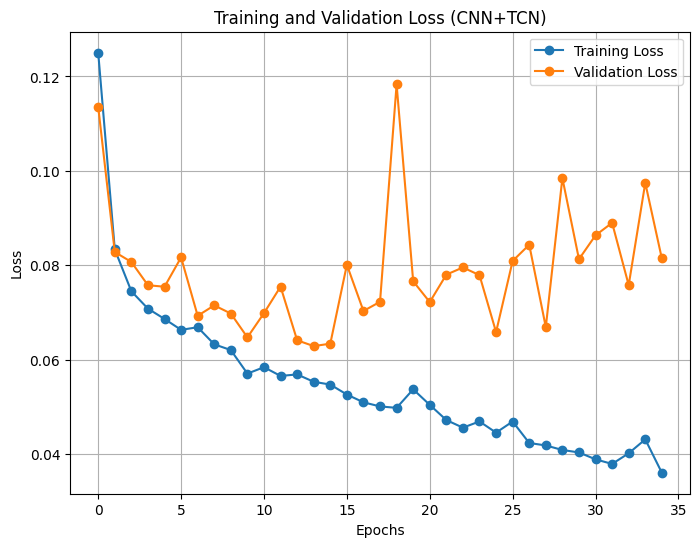

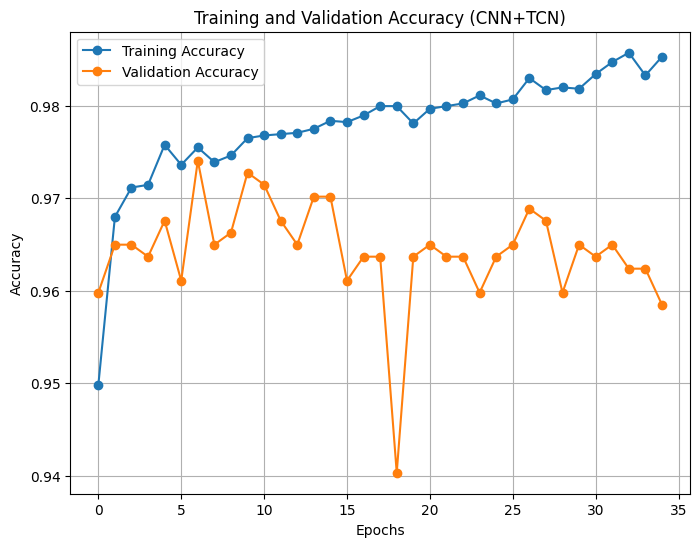

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9748 - loss: 0.0731
Test accuracy (CNN+TCN): 97.36%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.93      0.94      0.94       770

    accuracy                           0.97      3795
   macro avg       0.96      0.96      0.96      3795
weighted avg       0.97      0.97      0.97      3795



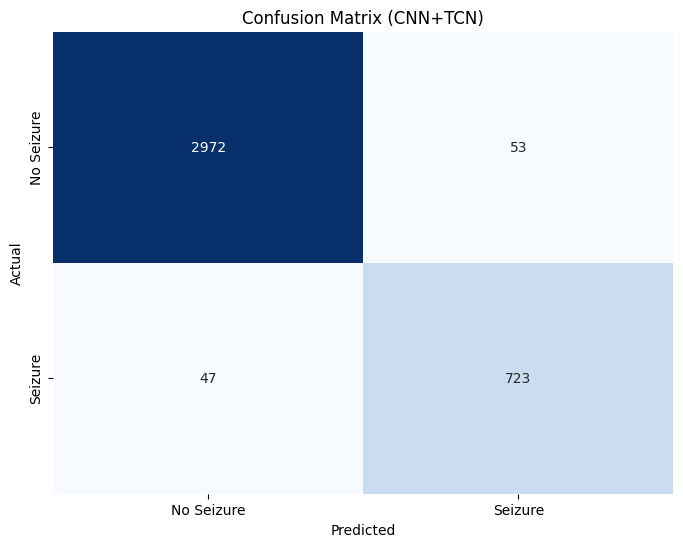

In [16]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=35, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

1D-CNN MODEL

Epoch 1/22


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9332 - loss: 0.2314 - val_accuracy: 0.9611 - val_loss: 0.0955
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.0815 - val_accuracy: 0.9702 - val_loss: 0.0766
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9687 - loss: 0.0751 - val_accuracy: 0.9676 - val_loss: 0.0744
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9712 - loss: 0.0704 - val_accuracy: 0.9676 - val_loss: 0.0743
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9702 - loss: 0.0725 - val_accuracy: 0.9676 - val_loss: 0.0734
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - loss: 0.0623 - val_accuracy: 0.9702 - val_loss: 0.0750
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9751 - loss: 0.0615 - val_accuracy: 0.9728 - val_loss: 0.0659
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9769 - loss: 0.0592 - val_accuracy: 0.9689 - val_

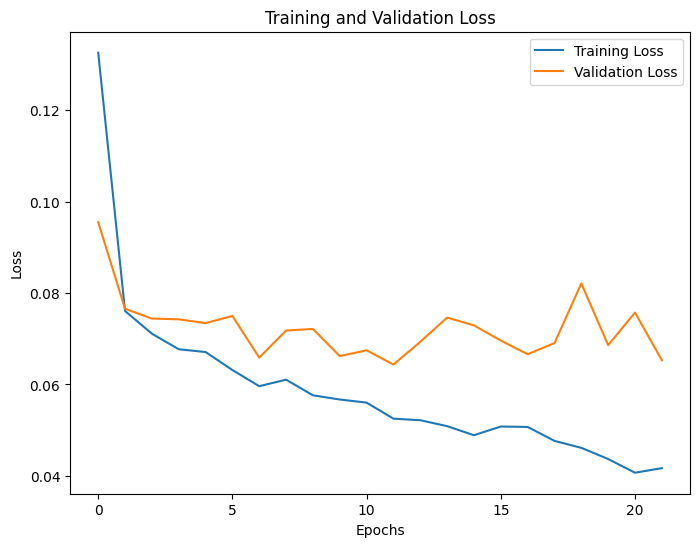

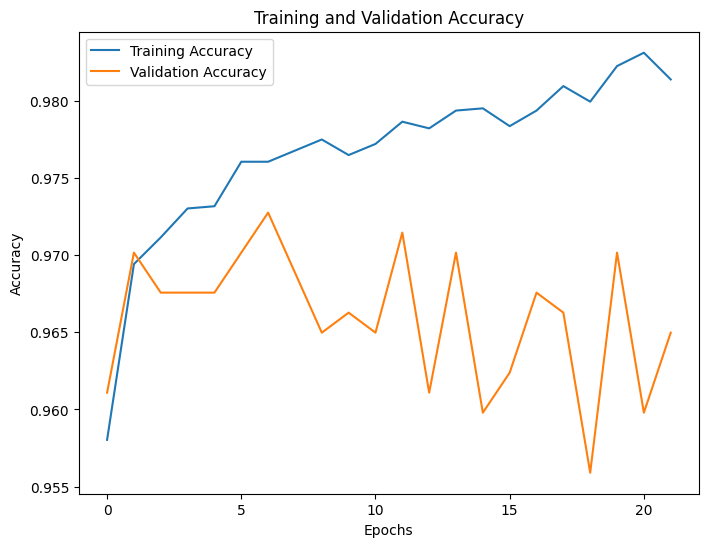

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9756 - loss: 0.0613
Test accuracy (CNN): 97.41765260696411%
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3025
           1       0.92      0.95      0.94       770

    accuracy                           0.97      3795
   macro avg       0.95      0.97      0.96      3795
weighted avg       0.97      0.97      0.97      3795



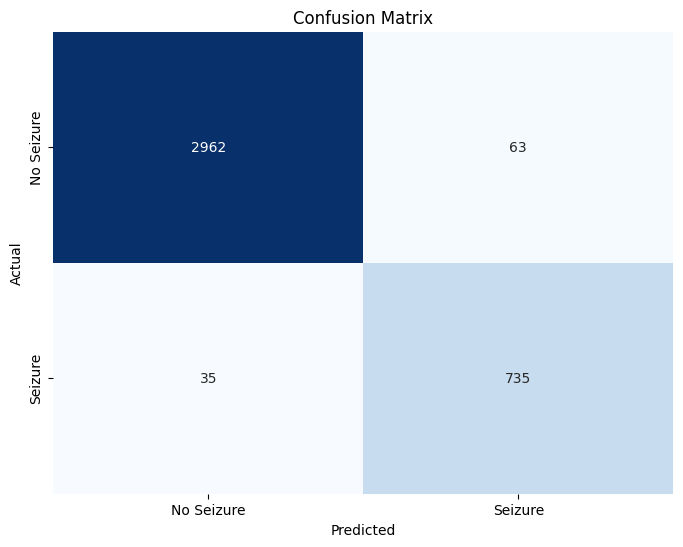

In [17]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'))  # Padding added
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'))  # Kernel size reduced, padding added
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model

# Assuming train_data and test_data are loaded correctly with correct shape
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]

model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating the model on test data
test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')

# Predictions and evaluation
predictions = model.predict(test_data)
predictions = (predictions > 0.5)

print("Classification Report:")
print(classification_report(test_labels, predictions))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to introduce class imbalance
def create_imbalance(X, y, imbalance_ratio=0.01):
    # Identify indices for the minority and majority classes
    minority_class_indices = np.where(y == 1)[0]
    majority_class_indices = np.where(y == 0)[0]

    # Calculate the number of samples to keep for each class
    num_minority_samples = len(minority_class_indices)
    num_majority_samples = int(num_minority_samples / imbalance_ratio)

    # Randomly sample from the majority class to create imbalance
    sampled_majority_indices = np.random.choice(majority_class_indices, num_majority_samples, replace=False)

    # Combine minority and sampled majority class indices
    selected_indices = np.concatenate((minority_class_indices, sampled_majority_indices))

    # Create the new balanced dataset
    X_imbalanced = X[selected_indices]
    y_imbalanced = y[selected_indices]

    return X_imbalanced, y_imbalanced

# Load and prepare your data
# Example data loading (replace with actual data loading logic)
# train_data, test_data, train_labels, test_labels should be prepared before this step

# Create class imbalance
imbalance_ratio = 0.01
train_data_imbalanced, train_labels_imbalanced = create_imbalance(train_data, train_labels, imbalance_ratio)
test_data_imbalanced, test_labels_imbalanced = create_imbalance(test_data, test_labels, imbalance_ratio)

# Define the CNN model
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model

# Reshape the data for CNN
train_data_imbalanced = train_data_imbalanced.reshape(train_data_imbalanced.shape[0], train_data_imbalanced.shape[1], 1)
test_data_imbalanced = test_data_imbalanced.reshape(test_data_imbalanced.shape[0], test_data_imbalanced.shape[1], 1)

# Define and compile the CNN
input_shape = train_data_imbalanced.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the CNN model on imbalanced data
history = model.fit(train_data_imbalanced, train_labels_imbalanced, epochs=35, batch_size=32, validation_split=0.1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the CNN model on the imbalanced test set
test_loss, test_acc_cnn = model.evaluate(test_data_imbalanced, test_labels_imbalanced)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')

# Make predictions
predictions = model.predict(test_data_imbalanced)
predictions = (predictions > 0.5)  

# Classification report
print("Classification Report:")
print(classification_report(test_labels_imbalanced, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(test_labels_imbalanced, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ValueError: Cannot take a larger sample than population when 'replace=False'

DECISION TREE MODEL

Decision Tree Classifier Accuracy: 96.83794466403161%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.92      0.93      0.92       770

    accuracy                           0.97      3795
   macro avg       0.95      0.95      0.95      3795
weighted avg       0.97      0.97      0.97      3795



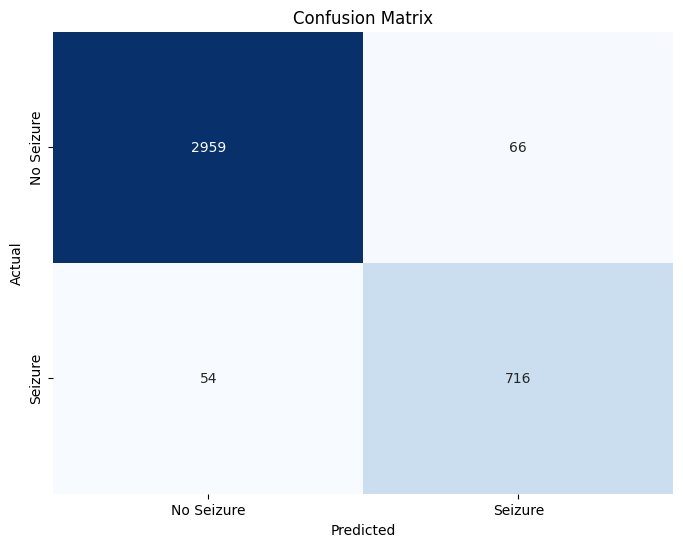

In [31]:
#DecisionTreeClassifier
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)
dt_predictions = dt_classifier.predict(test_data)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy*100}%')
print("Classification Report:")
print(classification_report(test_labels, dt_predictions))
conf_matrix = confusion_matrix(test_labels, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()




RANDOM FOREST MODEL

Random Forest Classifier Accuracy: 98.20816864295125%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.96      0.96       770

    accuracy                           0.98      3795
   macro avg       0.97      0.97      0.97      3795
weighted avg       0.98      0.98      0.98      3795



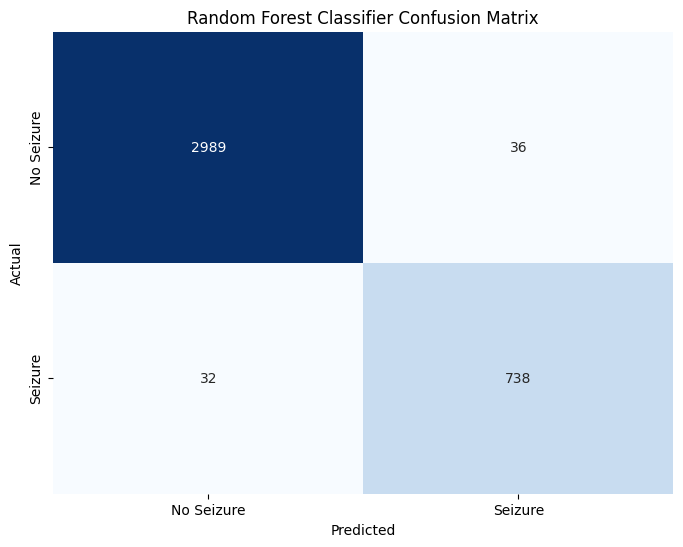

In [32]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



ADA BOOSTING

/home/rakesh018/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 97.60210803689064%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3025
           1       0.93      0.95      0.94       770

    accuracy                           0.98      3795
   macro avg       0.96      0.97      0.96      3795
weighted avg       0.98      0.98      0.98      3795



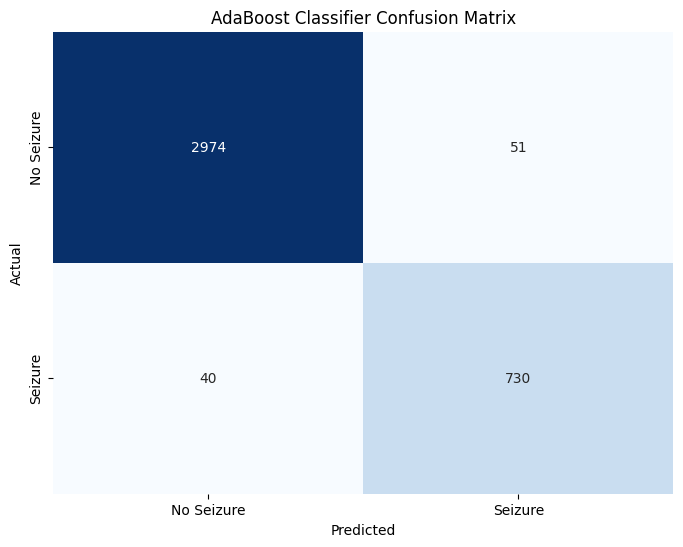

In [34]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM MODEL

SVM Classifier Test Accuracy: 97.78656126482214%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.94      0.95       770

    accuracy                           0.98      3795
   macro avg       0.97      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



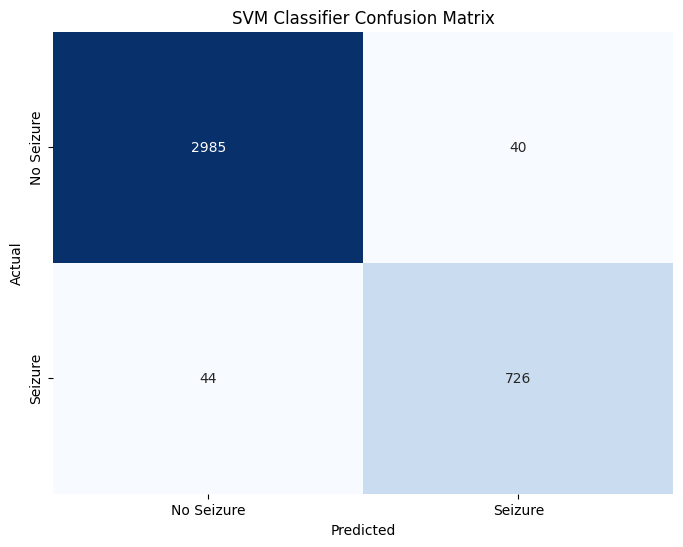

In [35]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN MODEL

KNN Classifier Accuracy: 97.15415019762847%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.92      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



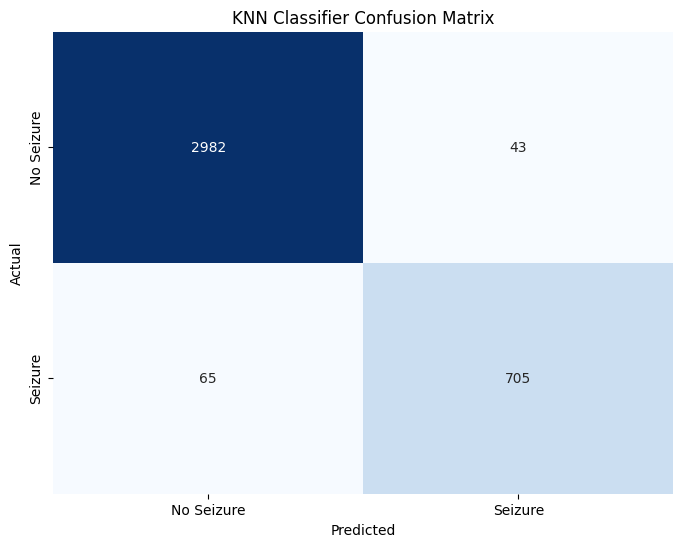

In [36]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



In [37]:
import matplotlib.pyplot as plt

accuracy_scores = [knn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy,adaboost_accuracy, test_acc_cnn,test_acc_lstm,ensemble_accuracy]
classifier_names = ['KNN', 'SVM', 'DCT', 'RF', 'ADA', 'CNN','LSTM','CNN+LSTM']

plt.figure(figsize=(12, 7)) 
bars = plt.bar(classifier_names, accuracy_scores, color=['purple', 'blue', 'red', 'green', 'lavender', 'orange', 'pink','yellow'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)  

for bar, label in zip(bars, accuracy_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(label, 2), ha='center', va='bottom')

plt.show()

NameError: name 'test_acc_cnn' is not defined

In [ ]:
DIRECTLY USING THE SIGNAL DATA INSTEAD OF FEATURE EXTRACTION AND COMPARE

In [41]:
# Load the dataset
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')

# Extract labels (assuming the last column contains the labels)
train_labels = train_data.iloc[:, -1].values
train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure

# Drop the first column and the label column from the features
train_data = train_data.iloc[:, 1:-1].values

# Split the data into 67% training and 33% testing
train_data, test_data, train_labels, test_labels = train_test_split(
    train_data, train_labels, test_size=0.33, random_state=42)

# Print the shapes of the resulting datasets
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train data shape: (7705, 178)
Test data shape: (3795, 178)
Train labels shape: (7705,)
Test labels shape: (3795,)


Decision Tree Classifier Accuracy: 94.39%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3025
           1       0.88      0.84      0.86       770

    accuracy                           0.94      3795
   macro avg       0.92      0.91      0.91      3795
weighted avg       0.94      0.94      0.94      3795



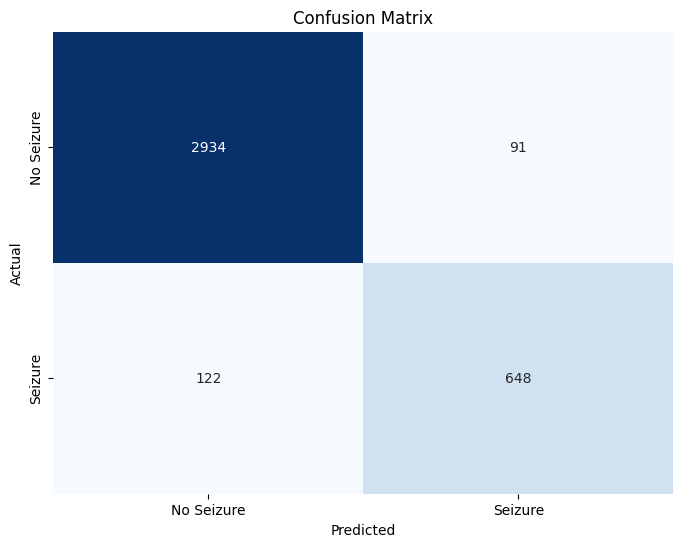

In [42]:
#DecisionTreeClassifier
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)

# Make predictions on the test set
dt_predictions = dt_classifier.predict(test_data)

# Calculate accuracy
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy*100:.2f}%')

# Print classification report
print("Classification Report:")
print(classification_report(test_labels, dt_predictions))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_labels, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest Classifier Accuracy: 97.31225296442688%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3025
           1       0.94      0.93      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.96      0.96      3795
weighted avg       0.97      0.97      0.97      3795



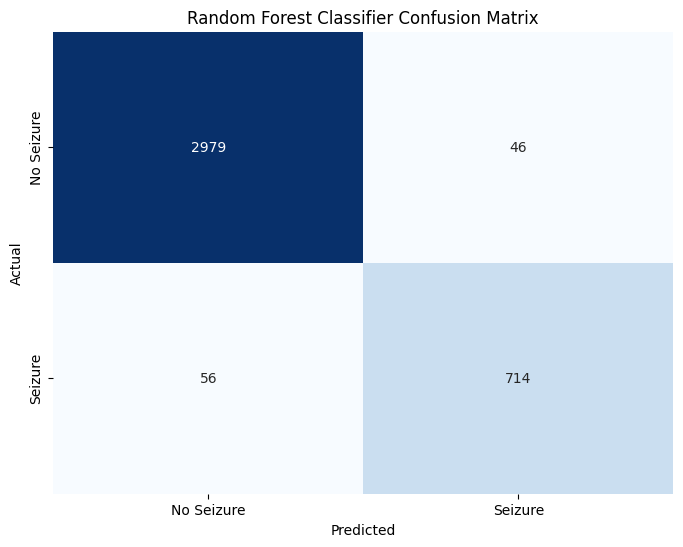

In [43]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/home/rakesh018/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Classifier Accuracy: 94.2292490118577%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      3025
           1       0.89      0.82      0.85       770

    accuracy                           0.94      3795
   macro avg       0.92      0.90      0.91      3795
weighted avg       0.94      0.94      0.94      3795



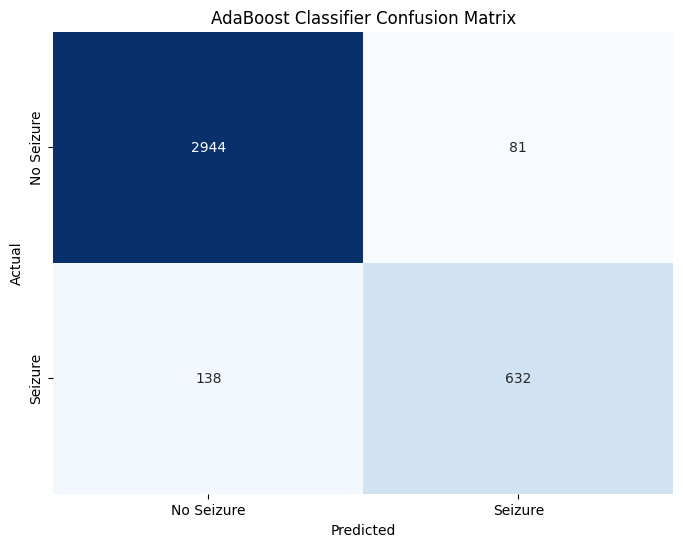

In [44]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM Classifier Test Accuracy: 97.23320158102767%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.96      0.90      0.93       770

    accuracy                           0.97      3795
   macro avg       0.97      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



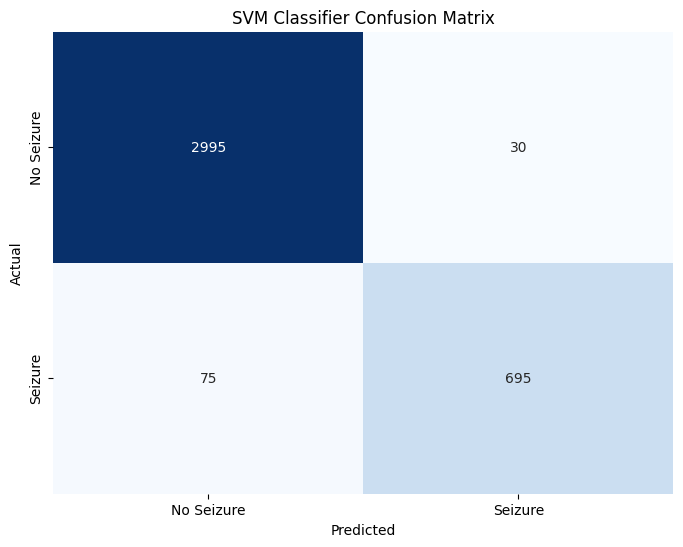

In [45]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN Classifier Accuracy: 91.9631093544137%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3025
           1       0.99      0.61      0.75       770

    accuracy                           0.92      3795
   macro avg       0.95      0.80      0.85      3795
weighted avg       0.93      0.92      0.91      3795



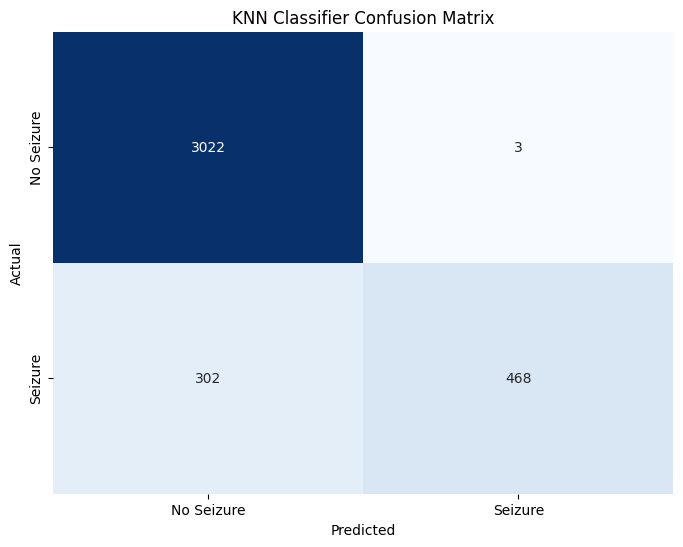

In [39]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/22


/home/rakesh018/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7144 - loss: 0.6691 - val_accuracy: 0.9209 - val_loss: 0.3070
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9449 - loss: 0.1893 - val_accuracy: 0.9844 - val_loss: 0.0732
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9793 - loss: 0.0603 - val_accuracy: 0.9702 - val_loss: 0.0738
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9837 - loss: 0.0550 - val_accuracy: 0.9857 - val_loss: 0.0674
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9821 - loss: 0.0512 - val_accuracy: 0.9857 - val_loss: 0.0378
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9877 - loss: 0.0422 - val_accuracy: 0.9883 - val_loss: 0.0354
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9885 - loss: 0.0304 - val_accuracy: 0.9831 - val_loss: 0.0615
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9897 - loss: 0.0305 - val_accuracy: 0.9844 - val_

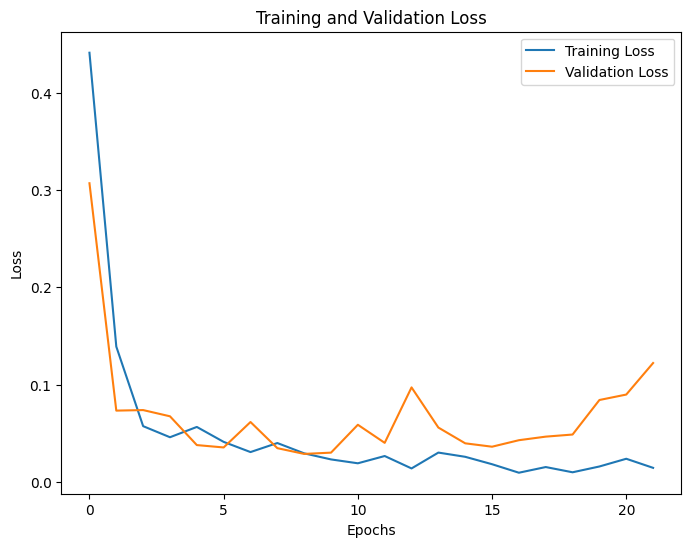

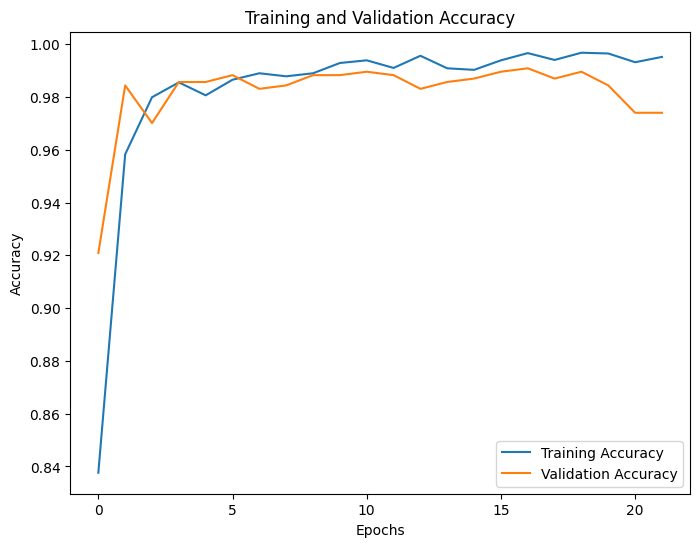

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9852 - loss: 0.0627
Test accuracy (CNN): 98.36627244949341%
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       0.99      0.92      0.96       770

    accuracy                           0.98      3795
   macro avg       0.99      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



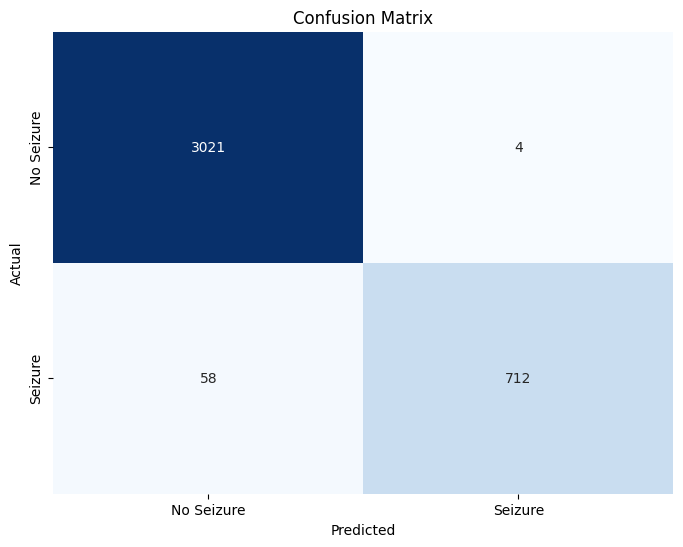

In [49]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=7, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 178, 64)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178, 64)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 178, 64)   │        128 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 178, 64)   │          0 │ conv1d_2[0][0],   │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 178, 64)   │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 178, 64)   │          0 │ activation[0][0], │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 178, 64)   │          0 │ add_1[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 178, 64)   │     12,352 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 178, 64)   │          0 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 178, 64)   │          0 │ activation_1[0][… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 178, 64)   │          0 │ add_2[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 178, 64)   │     12,352 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 103,489 (404.25 KB)

 Trainable params: 103,489 (404.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6017 - loss: 25.0105 - val_accuracy: 0.9040 - val_loss: 0.4009
Epoch 2/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.8082 - loss: 0.6957 - val_accuracy: 0.9066 - val_loss: 0.2971
Epoch 3/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9134 - loss: 0.3029 - val_accuracy: 0.9364 - val_loss: 0.2099
Epoch 4/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9409 - loss: 0.2064 - val_accuracy: 0.9637 - val_loss: 0.1517
Epoch 5/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9574 - loss: 0.1514 - val_accuracy: 0.9559 - val_loss: 0.1396
Epoch 6/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9621 - loss: 0.1299 - val_accuracy: 0.9235 - val_loss: 0.2284
Epoch 7/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9607 - loss: 0.1344 - val_accuracy: 0.9533 - val_loss: 0.1345
Epoch 8/22
217/217 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9608 - loss: 0.1341 - val_acc

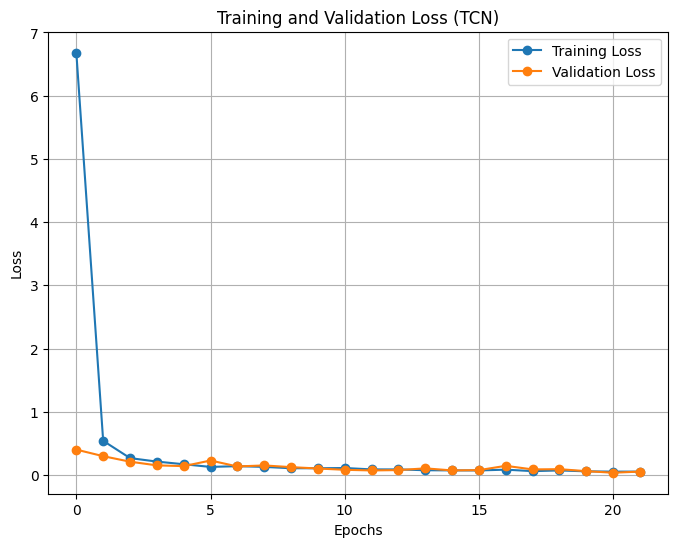

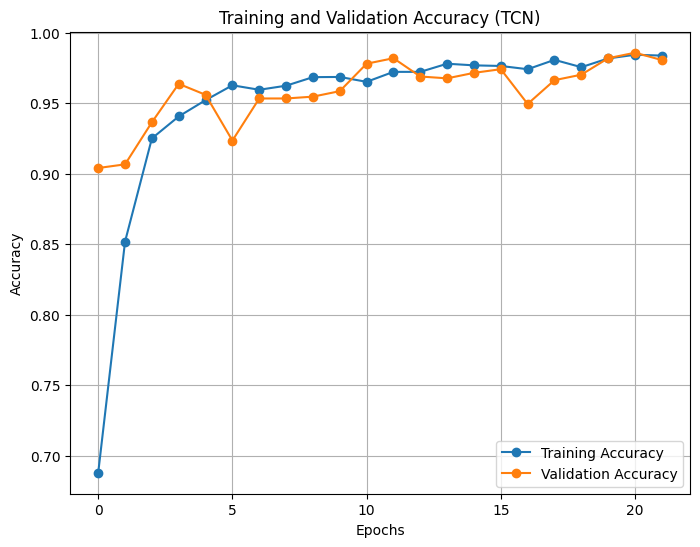

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9799 - loss: 0.0523
Test accuracy (TCN): 97.97%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Classification Report (TCN):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3025
           1       1.00      0.90      0.95       770

    accuracy                           0.98      3795
   macro avg       0.99      0.95      0.97      3795
weighted avg       0.98      0.98      0.98      3795



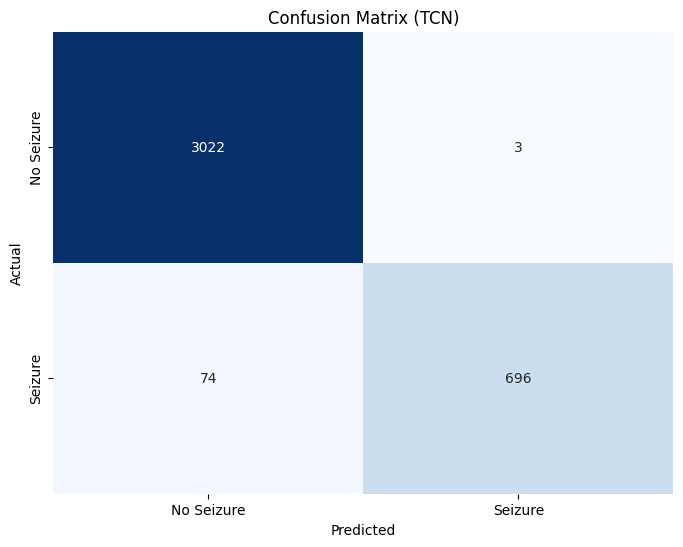

In [5]:
# Reshape data for TCN model
from tensorflow.keras import initializers
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

# Now, train_data.shape will be (7705, 52, 1)
# and test_data.shape will be (3795, 52, 1)

def create_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    """
    Creates a Temporal Convolutional Network (TCN) model.
    
    Parameters:
    - input_shape: tuple, shape of the input data (timesteps, features)
    - num_filters: int, number of filters for the Conv1D layers
    - kernel_size: int, size of the convolutional kernel
    - num_blocks: int, number of residual blocks
    - dropout_rate: float, dropout rate for regularization
    
    Returns:
    - model: Compiled TCN model
    """
    inputs = layers.Input(shape=input_shape)
    x = inputs
    
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        # First Conv1D layer in the residual block
        conv1 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(x)
        conv1 = layers.Dropout(dropout_rate)(conv1)
        
        # Second Conv1D layer in the residual block
        conv2 = layers.Conv1D(filters=num_filters,
                              kernel_size=kernel_size,
                              padding='causal',
                              dilation_rate=dilation_rate,
                              activation='relu',
                              kernel_initializer=initializers.HeNormal())(conv1)
        conv2 = layers.Dropout(dropout_rate)(conv2)
        
        # Residual connection
        if x.shape[-1] != conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, conv2])
        x = layers.Activation('relu')(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create TCN model
tcn_model = create_tcn(input_shape)

# Compile the model
tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
tcn_model.summary()

# Train the model
history = tcn_model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_tcn = tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (TCN): {test_acc_tcn*100:.2f}%')

# Predict on test data
predictions = tcn_model.predict(test_data)
predictions_binary = (predictions > 0.50).astype(int)

# Classification Report
print("Classification Report (TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 178, 32)   │        128 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_6     │ (None, 89, 32)    │          0 │ conv1d_39[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 89, 64)    │      6,208 │ max_pooling1d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_7     │ (None, 44, 64)    │          0 │ conv1d_40[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 44, 64)    │     12,352 │ max_pooling1d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 44, 64)    │          0 │ conv1d_41[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_32[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_33          │ (None, 44, 64)    │          0 │ conv1d_42[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 44, 64)    │          0 │ max_pooling1d_7[… │
│                     │                   │            │ dropout_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 44, 64)    │          0 │ add_16[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_16[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_34          │ (None, 44, 64)    │          0 │ conv1d_43[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 44, 64)    │     12,352 │ dropout_34[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_35          │ (None, 44, 64)    │          0 │ conv1d_44[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 44, 64)    │          0 │ activation_16[0]… │
│                     │                   │            │ dropout_35[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 44, 64)    │          0 │ add_17[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 44, 64)    │     12,352 │ activation_17[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_36          │ (None, 44, 64)    │          0 │ conv1d_45[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 121,793 (475.75 KB)

 Trainable params: 121,793 (475.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6970 - loss: 2.5733 - val_accuracy: 0.8768 - val_loss: 0.4719
Epoch 2/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9529 - loss: 0.1875 - val_accuracy: 0.9728 - val_loss: 0.0881
Epoch 3/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9642 - loss: 0.1233 - val_accuracy: 0.9780 - val_loss: 0.0666
Epoch 4/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9753 - loss: 0.0772 - val_accuracy: 0.9818 - val_loss: 0.0419
Epoch 5/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9791 - loss: 0.0579 - val_accuracy: 0.9767 - val_loss: 0.0881
Epoch 6/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9821 - loss: 0.0454 - val_accuracy: 0.9805 - val_loss: 0.0562
Epoch 7/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9792 - loss: 0.0628 - val_accuracy: 0.9935 - val_loss: 0.0253
Epoch 8/35
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9853 - loss: 0.0436 - val_accu

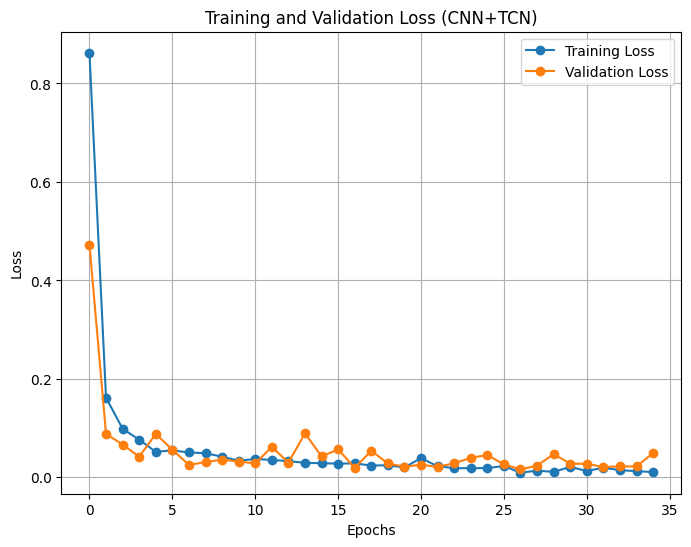

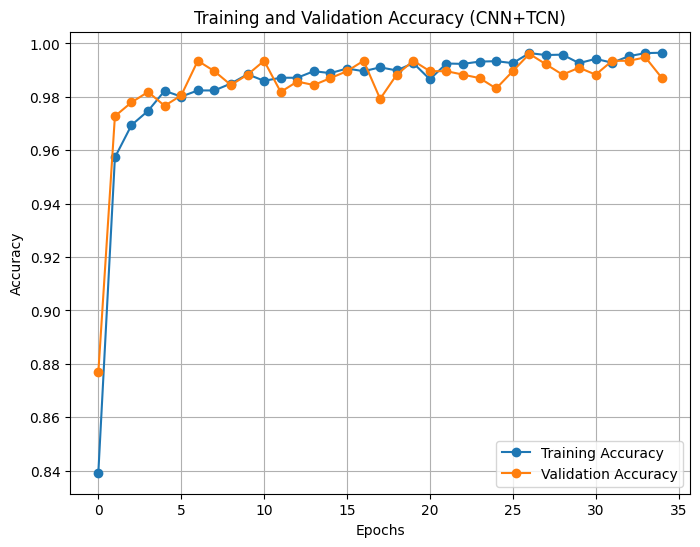

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9915 - loss: 0.0346
Test accuracy (CNN+TCN): 98.92%
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (CNN+TCN):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3025
           1       0.98      0.96      0.97       770

    accuracy                           0.99      3795
   macro avg       0.99      0.98      0.98      3795
weighted avg       0.99      0.99      0.99      3795



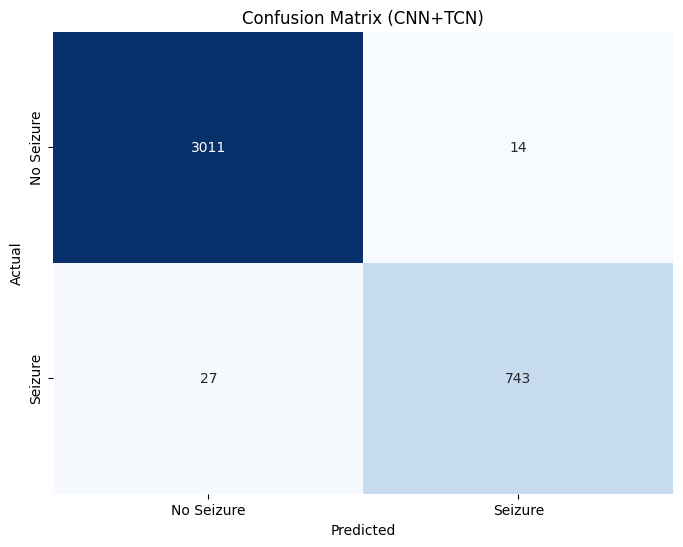

In [9]:
# Reshape data if necessary
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)

def create_cnn_tcn(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2):
    inputs = layers.Input(shape=input_shape)
    
    # CNN part
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    
    # TCN part
    for i in range(num_blocks):
        dilation_rate = 2 ** i
        tcn_conv1 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(x)
        tcn_conv1 = layers.Dropout(dropout_rate)(tcn_conv1)
        
        tcn_conv2 = layers.Conv1D(filters=num_filters,
                                  kernel_size=kernel_size,
                                  padding='causal',
                                  dilation_rate=dilation_rate,
                                  activation='relu',
                                  kernel_initializer=initializers.HeNormal())(tcn_conv1)
        tcn_conv2 = layers.Dropout(dropout_rate)(tcn_conv2)
        
        if x.shape[-1] != tcn_conv2.shape[-1]:
            x = layers.Conv1D(num_filters, kernel_size=1, padding='same')(x)
        x = layers.add([x, tcn_conv2])
        x = layers.Activation('relu')(x)
    
    # Global pooling and dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    return model

# Define input shape
input_shape = train_data.shape[1:]  # (timesteps, features)

# Create CNN+TCN model
cnn_tcn_model = create_cnn_tcn(input_shape)

# Compile the model
cnn_tcn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
cnn_tcn_model.summary()

# Train the model
history = cnn_tcn_model.fit(train_data, train_labels, epochs=35, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy (CNN+TCN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model on test data
test_loss, test_acc_cnn_tcn = cnn_tcn_model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN+TCN): {test_acc_cnn_tcn*100:.2f}%')

# Predict on test data
predictions = cnn_tcn_model.predict(test_data)
predictions_binary = (predictions > 0.5).astype(int)

# Classification Report
print("Classification Report (CNN+TCN):")
print(classification_report(test_labels, predictions_binary))

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix (CNN+TCN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()